In [1]:
import pandas as pd
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import QuantileAD
from adtk.detector import AutoregressionAD
from adtk.detector import SeasonalAD
import matplotlib.pyplot as plt


# 1 加载数据

In [2]:

all_data = pd.read_excel('/data/附件1：赛题A数据.xlsx', sheet_name='比赛数据-脱敏')
all_data = all_data.rename(columns={'时间': 'time', '小区内的平均用户数': 'avg_user', '基站编号':'base_id','小区编号': 'community_id',  '小区PDCP层所接收到的上行数据的总吞吐量比特': 'upward_throughput',
                                    '小区PDCP层所发送的下行数据的总吞吐量比特': 'downward_throughput', '平均激活用户数': 'avg_activate_users'})

f_train = all_data[['time', 'avg_user', 'base_id','community_id',
                  'upward_throughput', 'downward_throughput', 'avg_activate_users']]
train = f_train.copy()
train['id'] = all_data.index


# 1 小区分组

In [3]:
# 按小区分组，分成58个Dataframe
all_df = []
for id in train['community_id'].value_counts().keys():
    com_train = train.loc[train['community_id']==int(id)]
    # com_train = com_train.drop(columns =['time'])
    all_df.append(com_train)

# 2 第一个小区四个指标异常检测可视化

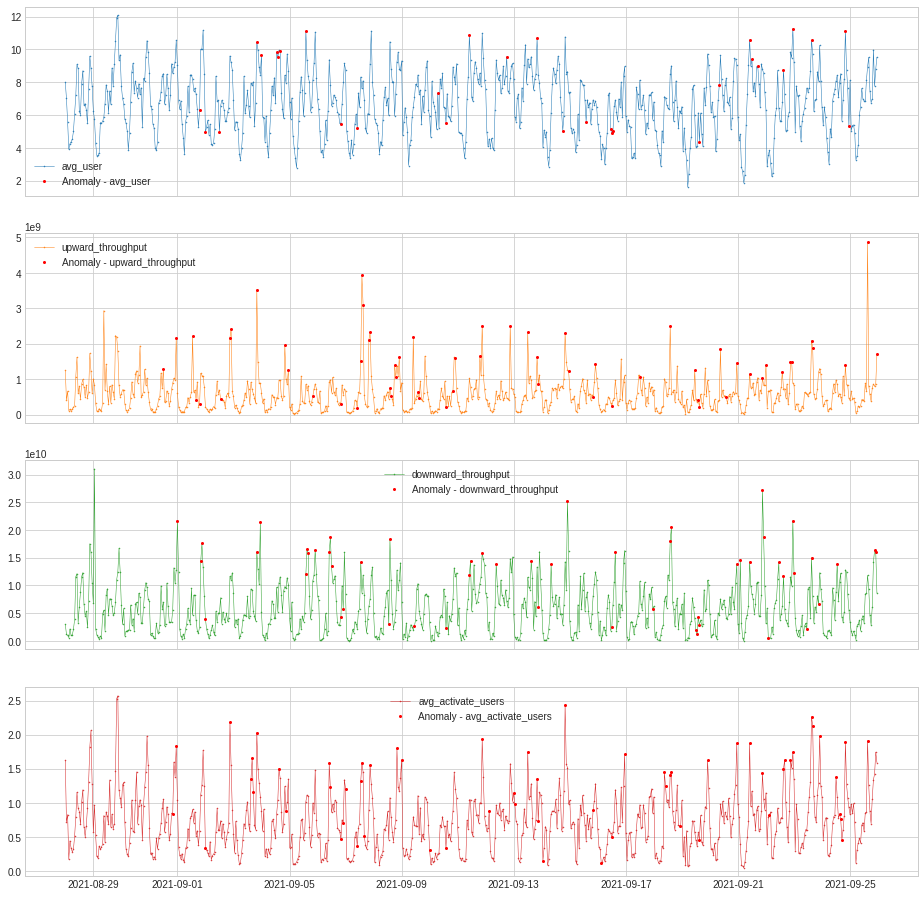

In [8]:
# 第一个小区，绘制平均激活用户指标 异常检测图
data_one = all_df[0]
data_one.index = pd.DatetimeIndex(data_one.time)
train_avg_user = data_one[['avg_user', 'upward_throughput', 'downward_throughput', 'avg_activate_users']]

df = validate_series(train_avg_user)
seasonal_ad = SeasonalAD(c=1, side="both")
anomalies1 = seasonal_ad.fit_detect(df)
autoregression_ad = AutoregressionAD(n_steps=7*1, step_size=12, c=1)
anomalies2 = autoregression_ad.fit_detect(df)
quantile_ad = QuantileAD(high=0.9, low=0.1)
anomalies3 = quantile_ad.fit_detect(df)


# plot(df, anomaly=anomalies1, ts_markersize=1, anomaly_color='red',
#      anomaly_tag="marker", anomaly_markersize=2) 
plot(df, anomaly=anomalies2, ts_markersize=1, anomaly_color='red',
     anomaly_tag="marker", anomaly_markersize=2)
# plot(df, anomaly=anomalies3, ts_markersize=1, anomaly_color='red',
#      anomaly_tag="marker", anomaly_markersize=2)
plt.savefig('com_1_detection.png')

# 3 统计每个指标异常点个数

In [9]:
kpi_df = []
# 取每个指标
dataset = []
for kpi in ['avg_user', 'upward_throughput', 'downward_throughput', 'avg_activate_users']:
    # 取每个小区
    error_count = 0
    all_community = []
    for j in range(len(all_df)):
        # print(j)
        com_1_train = all_df[j]
        com_1_train = com_1_train.copy()
        # 以时间戳作为索引
        com_1_train.index = pd.DatetimeIndex(com_1_train.time)
        # train_avg_user = train.drop(columns=['time', 'throughput', 'avg_activate_users'])
        # 只取平均用户这一个指标
        train_avg_user = com_1_train[[kpi]]

        df = validate_series(train_avg_user)
        autoregression_ad = AutoregressionAD(n_steps=7*1, step_size=12, c=1)
        anomalies1 = autoregression_ad.fit_detect(df)
        quantile_ad = QuantileAD(high=0.9, low=0.1)
        anomalies2 = quantile_ad.fit_detect(df)
        index_list = anomalies1.index
        # 按异常值索引给所有数据打标签
        label_name = 'label_tmp'
        for idx in index_list:
            tag1 = anomalies1.at[str(idx), kpi]
            tag2 = anomalies2.at[str(idx), kpi]
            # 取两种检测算法的并集
            if tag1 == True and tag2 == 1:
                com_1_train.loc[str(idx), label_name] = 1
                error_count += 1
            else:
                com_1_train.loc[str(idx), label_name] = 0
        com_1_train.index = list(range(len(com_1_train)))
        all_community.append(com_1_train)
    one_kpi_data = pd.concat(all_community)
    one_kpi_data.set_index(["id"], inplace=True)
    one_kpi_data.sort_index(inplace=True)
    kpi_df.append(one_kpi_data)
    print('{} 异常点有{}'.format(kpi, error_count))


avg_user 异常点有1288
upward_throughput 异常点有2252
downward_throughput 异常点有1753
avg_activate_users 异常点有1582


In [10]:
# 给每个指标打label
label_1 = kpi_df[0]['label_tmp']
label_2 = kpi_df[1]['label_tmp']
label_3 = kpi_df[2]['label_tmp']
label_4 = kpi_df[3]['label_tmp']
dataset = f_train.copy()
for i,kpi in enumerate(['avg_user', 'upward_throughput', 'downward_throughput', 'avg_activate_users']):
    l_name = '{}_label'.format(kpi)
    dataset[l_name] = kpi_df[i]['label_tmp']


In [ ]:
dataset["avg_user_label"].value_counts()


# 4 周期个数检验

In [11]:
com_df = []
for id in dataset['community_id'].value_counts().keys():
    com_train = dataset.loc[dataset['community_id'] == int(id)]
    com_df.append(com_train)


In [12]:

for kpi in ['avg_user', 'upward_throughput','downward_throughput', 'avg_activate_users']:
    # 取每个小区
    n = 0
    all_community = []
    for j in range(len(com_df)):
        # print(j)
        com_1_train = com_df[j]
        com_1_train = com_1_train.copy()
        label_name = '{}_label'.format(kpi)
        s = com_1_train[label_name].values.tolist()
        j = 0
        # 6的决定是根据傅里叶周期性判断分析得到的，具体看FFT_judge_Cycle.ipynb文件
        cycle_time = 6
        while j < len(s):
            if s[j:j+cycle_time].count(1) > 1:
                n += 1
            j += cycle_time
    print('{} 异常周期点有{}'.format(kpi, n))


avg_user 异常周期点有281
upward_throughput 异常周期点有488
downward_throughput 异常周期点有359
avg_activate_users 异常周期点有321


In [ ]:
# 测试异常周期个数算法
n = 0
s = [1, 1, 0, 0, 1, 1, 0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0]
print(len(s))
j = 0
while j<len(s):
    print(s[j:j+6])
    if s[j:j+6].count(1) > 1:
        n+=1
    j+=6
print(n)



In [90]:
dataset.to_csv('Or_detection_data.csv', index=False)


In [91]:
dataset


,time,avg_user,base_id,community_id,upward_throughput,downward_throughput,avg_activate_users,avg_user_label,upward_throughput_label,downward_throughput_label,avg_activate_users_label
0,2021-08-28 00:00,22.6341,1200071,26019014,1335290712,30825953056,2.7893,0.0,0.0,0.0,0.0
1,2021-08-28 00:00,19.1064,1200071,26019015,2829868592,14185653168,3.9198,0.0,0.0,0.0,0.0
2,2021-08-28 00:00,15.4729,1200071,26019016,1194709896,7767242120,3.1944,0.0,0.0,0.0,0.0
3,2021-08-28 00:00,0.0509,1200071,26019023,205800,137312,0.0004,0.0,0.0,0.0,0.0
4,2021-08-28 00:00,0.6355,1200071,26019024,12935840,26593440,0.0263,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
40363,2021-09-25 23:00,7.0792,1200075,26019033,371490528,1064325632,0.2405,0.0,0.0,0.0,0.0
40364,2021-09-25 23:00,1.3647,1200075,26019034,87614416,1651173776,0.0864,0.0,0.0,0.0,0.0
40365,2021-09-25 23:00,2.4111,1200075,26019035,219697536,2215657728,0.2187,0.0,0.0,0.0,0.0
40366,2021-09-25 23:00,11.7958,1200075,26019027,1506731744,22816769808,1.6753,0.0,0.0,1.0,0.0
